# HACKATHON PROJECT - 2 : Predicting which of the provided pairs of questions contain two questions with the same meaning.

# Group 3 : Rajesh Brid

# Date: 08/12/2018 & 09/12/2018

In [40]:
#Libraraies used
import os
os.getcwd()
os.chdir("F:\Rajesh\GreyAtom\quora")
os.getcwd()

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from os import path
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import RFE
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import  KNeighborsClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD

# Data exploration

In [2]:
# Read in training data

df_train = pd.read_csv("train.csv")
df_train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
df_train.shape

(404290, 6)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
# Read in Test data

df_test = pd.read_csv("test.csv")
#print "Number of testing data: %d" %len(test_data_raw)
df_test.head(5)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [7]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [9]:
df_test.shape

(2345796, 3)

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
test_id      int64
question1    object
question2    object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


In [11]:
len(df_train)

404290

In [12]:
df_test.describe

<bound method NDFrame.describe of          test_id                                          question1  \
0              0  How does the Surface Pro himself 4 compare wit...   
1              1  Should I have a hair transplant at age 24? How...   
2              2  What but is the best way to send money from Ch...   
3              3                        Which food not emulsifiers?   
4              4                   How "aberystwyth" start reading?   
5              5  How are the two wheeler insurance from Bharti ...   
6              6      How can I reduce my belly fat through a diet?   
7              7  By scrapping the 500 and 1000 rupee notes, how...   
8              8           What are the how best books of all time?   
9              9  After 12th years old boy and I had sex with a ...   
10            10        What is the best slideshow app for Android?   
11            11  What services are from Google: Facebook, YouTu...   
12            12  What if a cricket hits a 

In [13]:
df_train.describe

<bound method NDFrame.describe of             id    qid1    qid2  \
0            0       1       2   
1            1       3       4   
2            2       5       6   
3            3       7       8   
4            4       9      10   
5            5      11      12   
6            6      13      14   
7            7      15      16   
8            8      17      18   
9            9      19      20   
10          10      21      22   
11          11      23      24   
12          12      25      26   
13          13      27      28   
14          14      29      30   
15          15      31      32   
16          16      33      34   
17          17      35      36   
18          18      37      38   
19          19      39      40   
20          20      41      42   
21          21      43      44   
22          22      45      46   
23          23      47      48   
24          24      49      50   
25          25      51      52   
26          26      53      54   
27          27

Number of Train data: 404290
Ratio of duplicate question pairs: 36.920000
Total number of questions: 537933
Number of questions appearing multiple times: 111780


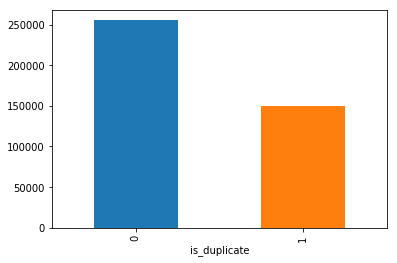

In [14]:
# Statistics of Train data

print ("Number of Train data: %d" %len(df_train))
print ("Ratio of duplicate question pairs: %f" %round(df_train['is_duplicate'].mean()*100,2))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print ("Total number of questions: %d" %len(np.unique(qids)))
print ("Number of questions appearing multiple times: %d" %np.sum(qids.value_counts()>1))
df_train.groupby("is_duplicate")['id'].count().plot.bar()

In [15]:
qids

0              1
1              3
2              5
3              7
4              9
5             11
6             13
7             15
8             17
9             19
10            21
11            23
12            25
13            27
14            29
15            31
16            33
17            35
18            37
19            39
20            41
21            43
22            45
23            47
24            49
25            51
26            53
27            55
28            57
29            59
           ...  
808550       691
808551    124172
808552    466328
808553    537906
808554    537908
808555     16064
808556    146284
808557    290649
808558    537910
808559    349794
808560     35364
808561    537914
808562     14005
808563    537916
808564     87385
808565    537917
808566    308365
808567    537918
808568    169786
808569    537921
808570    537923
808571     81495
808572     16773
808573    537925
808574    537927
808575    379845
808576    155606
808577    5379

# Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud.

(-0.5, 1279.5, 979.5, -0.5)

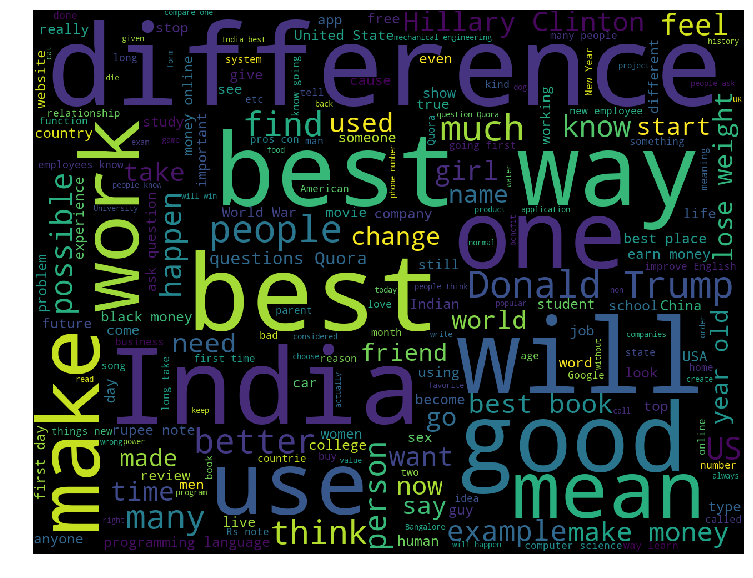

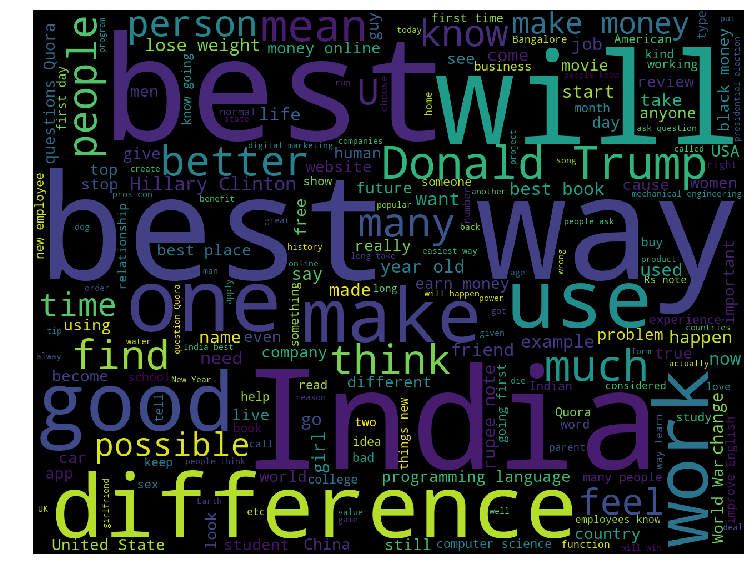

In [16]:
#Check out the most common words in word cloud graph from training data.

# most occuring words in Question 1
cloud1 = WordCloud(width=1280, height=980).generate(" ".join(df_train['question1'].astype(str)))

# most occuring words in Question 2
cloud2 = WordCloud(width=1280, height=980).generate(" ".join(df_train['question2'].astype(str)))

# Display Question 1 & 2 word cloud

plt.figure(figsize=(15, 10))
plt.imshow(cloud1)
plt.axis('off')
plt.figure(figsize=(15, 10))
plt.imshow(cloud2)
plt.axis('off')

# Data Processing

In [79]:
# Functions to calculate common words and TFIDF word share

In [17]:
# Function to calculate normalized common word between Question 1 & Question 2

def common_words(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [18]:
# Combine all questions into corpus for TFIDF analysis

train_questions = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_questions  = pd.Series(df_test['question1'].tolist()  + df_test['question2'].tolist()).astype(str)

# Implement TFIDF function

def get_weight(count, eps=5000, min_count=2):
    if count < min_count:
        return 0                    # remove words only appearing once 
    else:
        R = 1.0 / (count + eps)
        return R

eps = 5000 
words   = (" ".join(train_questions)).lower().split()
counts  = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

print ("Most common words: ", (sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10]))

Most common words:  [('the', 2.623060902228028e-06), ('what', 3.164927538983995e-06), ('is', 3.651647440742891e-06), ('how', 4.463907079310237e-06), ('i', 4.5832664940302954e-06), ('a', 4.646127684881036e-06), ('to', 4.783155639101341e-06), ('in', 5.006909535158519e-06), ('of', 6.100834594172483e-06), ('do', 6.260956674179815e-06)]


In [19]:
# Calculate TFIDF word match share as our new feature

def tfidf_common_words(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" "))) 
    if len(w1)==0 or len(w2)==0:
        return 0
    
    common = w1 & w2
    share_weight = [weights.get(word, 0) for word in common]
    total_weight = [weights.get(word, 0) for word in w1]+[weights.get(word, 0) for word in w2]
    
    return np.sum(share_weight)/np.sum(total_weight)

In [20]:
# Construct features for training data: character length, number of words, normalized common words 

train_data = pd.DataFrame(dtype='float64')

train_data['q1chrlen'] = df_train['question1'].str.len()
train_data['q2chrlen'] = df_train['question2'].str.len()
train_data['q1_nword'] = df_train['question1'].apply(lambda x: len(str(x).split(" ")))
train_data['q2_nword'] = df_train['question2'].apply(lambda y: len(str(y).split(" ")))

train_data['word_share']  = df_train.apply(common_words, axis=1)
train_data['TFIDF_share'] = df_train.apply(tfidf_common_words, axis=1, raw=True)

train_data.head()

,q1chrlen,q2chrlen,q1_nword,q2_nword,word_share,TFIDF_share
0,66.0,57.0,14,12,0.434783,0.400611
1,51.0,88.0,8,13,0.200000,0.193056
2,73.0,59.0,14,10,0.166667,0.149204
3,50.0,65.0,11,9,0.000000,0.000000
4,76.0,39.0,13,7,0.100000,0.009949


In [84]:
# Replace if there's NaN values in the data

In [21]:
np.sum(np.isnan(train_data))
train_data.loc[:,'q2chrlen'] = np.nan_to_num(train_data.loc[:,'q2chrlen'])
np.sum(np.isnan(train_data))

q1chrlen       1
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

In [22]:
train_data['q1chrlen']

0          66.0
1          51.0
2          73.0
3          50.0
4          76.0
5          86.0
6          19.0
7          30.0
8          31.0
9          60.0
10         57.0
11         43.0
12         36.0
13         43.0
14        141.0
15         93.0
16         28.0
17         57.0
18         82.0
19         60.0
20         26.0
21         37.0
22         47.0
23         24.0
24         79.0
25         79.0
26         24.0
27         49.0
28         38.0
29         38.0
          ...  
404260     32.0
404261     58.0
404262     41.0
404263     66.0
404264     78.0
404265     33.0
404266     58.0
404267     52.0
404268     60.0
404269     52.0
404270     43.0
404271     80.0
404272     83.0
404273     47.0
404274     62.0
404275     60.0
404276     26.0
404277     23.0
404278     41.0
404279     66.0
404280     51.0
404281     68.0
404282     43.0
404283     88.0
404284     42.0
404285     85.0
404286     41.0
404287     17.0
404288     94.0
404289     37.0
Name: q1chrlen, Length: 

In [23]:
xx= train_data[train_data['q1chrlen'].isnull()]

In [24]:
xx

,q1chrlen,q2chrlen,q1_nword,q2_nword,word_share,TFIDF_share
363362,NaN,123.0,1,21,0.0,0.0


In [89]:
np.sum(np.isnan(train_data))
train_data.loc[:,'q1chrlen'] = np.nan_to_num(train_data.loc[:,'q1chrlen'])
np.sum(np.isnan(train_data))

q1chrlen       0
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

In [25]:
# Process test data to have the same features as training data

test_data = pd.DataFrame()
test_data['q1chrlen'] = df_test['question1'].str.len()
test_data['q2chrlen'] = df_test['question2'].str.len()
test_data['q1_nword'] = df_test['question1'].apply(lambda x: len(str(x).split(" ")))
test_data['q2_nword'] = df_test['question2'].apply(lambda y: len(str(y).split(" ")))
test_data['word_share']  = df_test.apply(common_words, axis=1)
test_data['TFIDF_share'] = df_test.apply(tfidf_common_words, axis=1, raw=True)

# Replace NaN if any

np.sum(np.isnan(test_data))
test_data.loc[:,['q1chrlen','q2chrlen']] = np.nan_to_num(test_data.loc[:,['q1chrlen','q2chrlen']])
np.sum(np.isnan(test_data))

q1chrlen       0
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

# Feature Visualization

C:\Users\Rajesh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Rajesh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Probability')

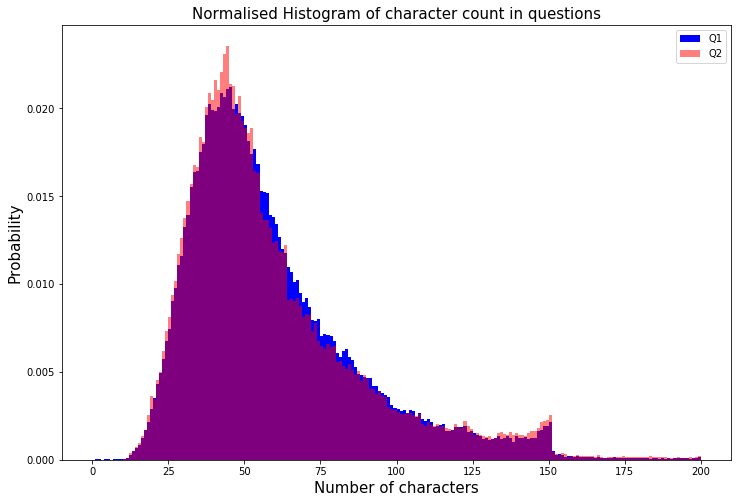

In [26]:
# visualization on character count

plt.figure(figsize=(12, 8))
plt.hist(train_data['q1chrlen'], bins=200, range=[0, 200], color='blue', normed=True, label='Q1')
plt.hist(train_data['q2chrlen'], bins=200, range=[0, 200], color='red',alpha = 0.5, normed=True, label='Q2')

plt.title('Normalised Histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

C:\Users\Rajesh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Rajesh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Probability')

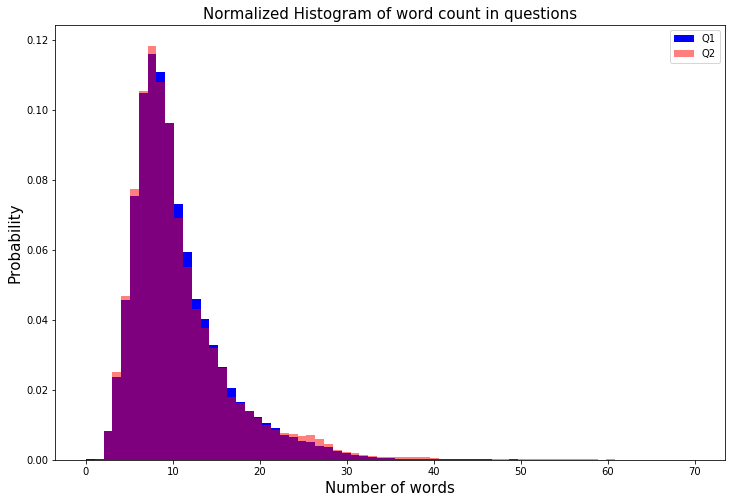

In [27]:
# Visualization on word count

plt.figure(figsize=(12, 8))
plt.hist(train_data['q1_nword'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='blue', label='Q1')
plt.hist(train_data['q2_nword'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='red',alpha = 0.5, label='Q2')
plt.title('Normalized Histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

C:\Users\Rajesh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Rajesh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'word_share_ratio')

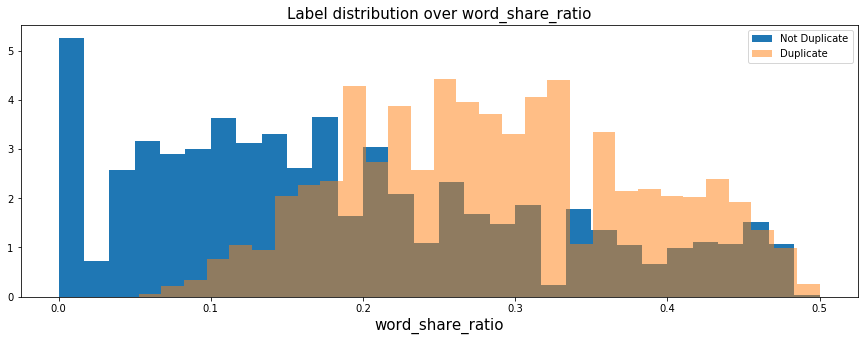

In [30]:
# Visualization on common words

plt.figure(figsize=(15, 5))
train_word_share = train_data['word_share']
plt.hist(train_word_share[df_train['is_duplicate'] == 0], bins=30, normed=True, label='Not Duplicate')
plt.hist(train_word_share[df_train['is_duplicate'] == 1], bins=30, normed=True, alpha=0.5, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_share_ratio', fontsize=15)
plt.xlabel('word_share_ratio', fontsize=15)

C:\Users\Rajesh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Rajesh\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'TFIDF_share')

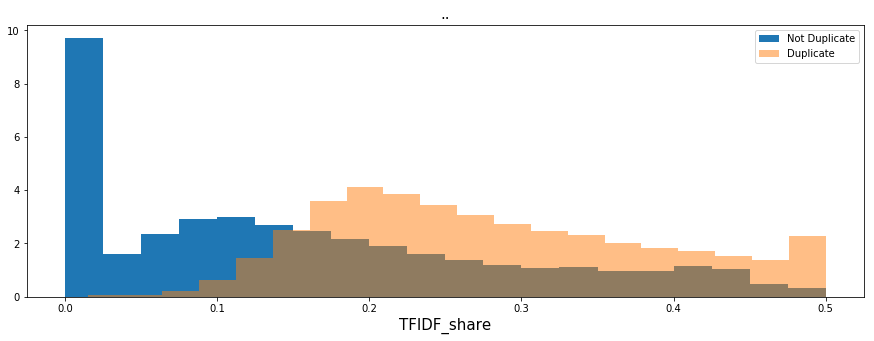

In [31]:
# Visualization on TFIDF common words

plt.figure(figsize=(15, 5))
train_tfidf = train_data['TFIDF_share'].fillna(0)
plt.hist(train_tfidf[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_tfidf[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.5, label='Duplicate')
plt.legend()
plt.title('..', fontsize=15)
plt.xlabel('TFIDF_share', fontsize=15)

# As one would expect, the word share ratio is higher for duplicate question pairs.

# Now we normalized all features for better machine learning accuracy.

In [32]:
# Normalized feature values

scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled  = scaler.fit_transform(test_data)

C:\Users\Rajesh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Rajesh\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Rajesh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Rajesh\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [33]:
# Split training data to train and validation data sets

label = df_train['is_duplicate']
X_train, X_valid, y_train, y_valid = train_test_split(train_data, label, test_size=0.2, random_state=10)
X_train_scaled, X_valid_scaled, y_train, y_valid = train_test_split(train_data_scaled, label, test_size=0.2, random_state=10)

In [100]:
# Compare Supervised Learning Models

# Model 1: Logistic Regression model

In [102]:
# Use GridSearch cross validation to find best parameter

lr = LogisticRegression(random_state=10)
grid = {
    'C': [1e-6, 1e-3, 1e0, 1e3, 1e6],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(lr, grid, scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print (cv.best_params_)

score_lr = cv.best_estimator_.score(X_valid_scaled, y_valid)

print ("Logistic regression model accuracy: %.3f" %score_lr)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   22.0s finished


{'C': 1000000.0, 'penalty': 'l1'}
Logistic regression model accuracy: 0.669


In [103]:
lr = LogisticRegression(C = 1000, penalty = 'l2', random_state=10)
lr.fit(X_train_scaled, y_train)
prediction = lr.predict_proba(test_data_scaled)

In [104]:
print (prediction)

[[0.72082935 0.27917065]
 [0.43929608 0.56070392]
 [0.41257524 0.58742476]
 ...
 [0.88550993 0.11449007]
 [0.21740946 0.78259054]
 [0.48737104 0.51262896]]


# Model 2: Decision tree

In [109]:
dt = DecisionTreeClassifier(max_depth = 100, random_state=10)
dt.fit(X_train_scaled, y_train)
prediction = dt.predict(X_valid_scaled)
score_dt = dt.score(X_valid_scaled, y_valid)
print ("Decision tree model accuracy: %.3f" %score_dt)

Decision tree model accuracy: 0.698


In [110]:
prediction = dt.predict_proba(test_data_scaled)
print (prediction)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


# Model 3 : Random Forest

In [112]:
rfc = RandomForestClassifier(max_depth=5, random_state=0)
rfc.fit(X_train_scaled,y_train)
prediction = rfc.predict_proba(X_valid_scaled)
pre = rfc.predict(X_valid_scaled)
score_rfc = rfc.score(X_valid_scaled, y_valid)
print ("Random Forest has accuracy: %.3f" %score_rfc)

Random Forest has accuracy: 0.721


In [113]:
prediction = rfc.predict_proba(test_data_scaled)
print (prediction)

[[0.56572456 0.43427544]
 [0.43872036 0.56127964]
 [0.43872036 0.56127964]
 ...
 [0.95481205 0.04518795]
 [0.49965175 0.50034825]
 [0.50419779 0.49580221]]


# Model 4: SVM model

In [115]:
# Use GridSearch cross validation to find best parameter

svm = SVC(random_state=0, max_iter=500, probability=True)
grid = {
    'C': [1e-3, 1e0, 1e3],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
cv = GridSearchCV(svm, grid, scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print (cv.best_params_)
score_svm = cv.best_estimator_.score(X_valid_scaled, y_valid)
print ("SVM model accuracy: %.3f" %score_svm)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 30.2min finished


{'C': 1.0, 'kernel': 'sigmoid'}
SVM model accuracy: 0.491


In [116]:
svm = SVC(random_state=0, max_iter=1000, probability=True, kernel='sigmoid', C=0.001)
svm.fit(X_train_scaled, y_train)
prediction = svm.predict_proba(test_data_scaled)
print (prediction)

[[0.65274943 0.34725057]
 [0.58880806 0.41119194]
 [0.61683679 0.38316321]
 ...
 [0.70197224 0.29802776]
 [0.63370945 0.36629055]
 [0.61750675 0.38249325]]


# Model 5: K Nearest Neighbors

In [118]:
# Use grid search for best parameter

knn = KNeighborsClassifier()
grid = {
    'n_neighbors': list(range(2, 10, 2)),
    'weights': ['uniform', 'distance']
}
cv = GridSearchCV(knn, grid, scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print (cv.best_params_)
score_knn = cv.best_estimator_.score(X_valid_scaled, y_valid)
print ("K Nearest Neighbor model accuracy: %.3f" %score_knn)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  9.2min finished


{'n_neighbors': 8, 'weights': 'uniform'}
K Nearest Neighbor model accuracy: 0.719


# Model 6: Naive Bayes model

In [120]:
mnb = MultinomialNB().fit(X_train, y_train)
score_nb = mnb.score(X_valid,y_valid)
print ("Naive Bayes model accuracy: %.3f" %score_nb)

Naive Bayes model accuracy: 0.633


In [121]:
prediction = mnb.predict_proba(test_data)
print (predictionction)

[[0.69226641 0.30773359]
 [0.57320792 0.42679208]
 [0.53759866 0.46240134]
 ...
 [0.68138396 0.31861604]
 [0.66077997 0.33922003]
 [0.61710374 0.38289626]]


# Model 7: XGBoost 

In [36]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train_scaled, label=y_train)
d_valid = xgb.DMatrix(X_valid_scaled, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=10)
d_test = xgb.DMatrix(test_data_scaled)
p_test = bst.predict(d_test)

[12:10:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-logloss:0.686721	valid-logloss:0.686709
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[12:10:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:10:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:10:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:10:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:10:55] C:\Users\Administrator\Desktop\xg

[12:11:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:11:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:11:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[12:11:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[110]	train-logloss:0.489218	valid-logloss:0.489239
[12:11:09] C:\Users\Administrator\Desktop\

[12:11:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:11:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:11:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[160]	train-logloss:0.4776	valid-logloss:0.477822
[12:11:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:11:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:11:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:11:17] C:\Users\Administrator\Desktop\xg

[12:11:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[12:11:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:11:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:11:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:11:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:11:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:11:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[12:11:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[12:11:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:11:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[12:11:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:11:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[12:11:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:11:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[12:11:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:11:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:11:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:11:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[320]	train-logloss:0.46839	valid-logloss:0.468981
[12:11:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:11:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:11:39] C:\Users\Administrator\Desktop\x

[12:11:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[370]	train-logloss:0.466915	valid-logloss:0.467624
[12:11:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:11:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:11:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:11:47] C:\Users\Administrator\Desktop\

[12:11:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:11:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[12:12:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:12:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:12:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:12:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:12:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[480]	train-logloss:0.463451	valid-logloss:0.464449
[12:12:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:12:02] C:\Users\Administrator\Desktop\